
## Introduction  

The objective of this project is to rank telecom carriers for businesses by leveraging a variety of attributes. These include data points such as unique device IDs, geographical coordinates of device signal locations, the distance between these signal points and business addresses, as well as device-specific details like categories and models. The analysis aims to uncover patterns and insights that inform carrier rankings.  

### Problem Statement  

The challenge is to design a robust solution for ranking telecom carriers tailored to the needs of individual businesses. This involves analyzing diverse factors provided in the dataset, such as the location of device signals relative to business addresses, the categories and models of devices, and other related attributes. The goal is to derive a ranking system that captures the relevance and suitability of each carrier for specific business requirements.  


### Approach 

The approach involves clustering businesses based on their feature profiles and using Singular Value Decomposition (SVD) as a latent factor model to uncover hidden patterns in the data. SVD is a matrix factorization technique commonly used in recommendation systems, which works by decomposing a matrix into three smaller matrices. These matrices reveal latent features that are not explicitly observed in the original data but are inferred from the relationships between the entries.

In our case, SVD will help uncover latent factors that influence the ranking of carriers. These factors are abstract concepts which are not observable/quantifiable but influence our data nonetheless. For our use-case related to telecom carriers, some potential latent factors could be notions like "reliability", "coverage", "network performance" etc. The **key hypothesis** is that there are shared latent factors between two sets of data: **Q** (representing carrier data with latent structure) and **B** (which includes observable business features). If these two matrices indeed share some underlying latent structure, then the latent factors derived from **Q** (via SVD) can be used to map businesses to their most suitable carriers and also produce a ranking. Essentially, we hypothesize that the same underlying factors that explain **Q** also have a bearing on **B**, helping to reveal hidden patterns that can be exploited to understand which business-carrier pairs are strongest.


### Steps Followed^

- **Quality Matrix (QM) Creation:** 
   We first form a "quality matrix" for the carriers. The columns of the matrix are engineered attributes such as:
    1) **Device Count**: Total number of unique devices associated with a carrier or business.
     - For a carrier, this reflects their market penetration and popularity.
     - For a business, it represents the volume of devices interacting with the business location, offering insight into the scale of operations and foot traffic.

    2) **Corporate Percentage**: The proportion of corporate (business) users among the total devices.
     - For a carrier, a higher corporate percentage indicates a focus on business users, which might appeal to businesses requiring reliable, enterprise-grade services.
     - For a business, this metric highlights the proportion of professional vs. casual users visiting the location, influencing carrier preferences.

    3) **Median Distance from Business Location**: Median of the distances between device signal locations and the business location.
     - For a carrier, a smaller median distance suggests better coverage reliability near business locations.
     - For a business, it represents the typical proximity of visitors, helping to determine if nearby carriers are better suited for their needs.

    4) **Coverage Variability**: Absolute difference between the mean and median of the `distance_from_biz_loc` for each carrier or business.
     - For a carrier, this measures consistency in signal coverage, where lower variability indicates uniform service quality (i.e. if mean and median are quite different it might indicate geographical spread between signals).
     - For a business, it reflects the spread of devices’ distances, indicating whether the business has a localized or diverse audience (in terms of geo-location).


- **SVD Decomposition:** 
   We apply SVD to the quality matrix to reveal the latent factors influencing carrier performance. These latent factors could represent features like "reliability", "coverage", or "network performance" *(explained in more detail in the notebook below).*

- **Business-Feature Matrix Creation:** 
   We then create a "business-feature matrix" with the same five attributes as in the QM, but for business IDs instead of carriers.

- **Projection into Latent Factor Space:** 
   The business-feature matrix is projected into the latent factor space derived from the SVD of the quality matrix.

- **Similarity Matrix Calculation:** 
   A similarity matrix is created by calculating the similarity between the business-feature matrix and the quality matrix for the carriers. This will give us similarity scores for business-carrier pairs.

- **Clustering and Ranking:** 
   Businesses are clustered into segments based on their feature profiles. Within each business segment, carriers are ranked according to their similarity scores.

This methodology allows for a tailored ranking of telecom carriers, helping businesses find the best-suited carrier based on multiple factors and hidden relationships revealed through SVD.

***************************************************************
^**Important assumptions**:

- We experimented with engineering additional attributes, such as leveraging Latitude/Longitude data to capture geospatial spread. While notable geospatial spread was observed at the carrier level, the business-location (address_id-level) spread was minimal, resulting in a sparse business-feature matrix unsuitable for analysis. This is likely due to the data being limited to a single US state. In a larger dataset covering a more diverse geographic region, this attribute could prove more informative.

- In addition to our proposed hypothesis, another reason behind the inclusion of a clustering step for business locations was motivated by the fact that a single address_id could correspond to multiple business_ids. As a result, several businesses may share the same set of attributes derived from the geofenced data.

- We have considered the column `mapping_carrier` and not `carrier`. This was primarily because the former is a smaller set of carrier names and doing the analysis was more tractable. The latter column has many fringe cases where the volume was too low. Moreover, we provide a check at the very end of the notebook under "Appendix" to show that the results remain the same.

- We have made the assumption that carriers where there is less than 200 rows of tabular data should be dropped from analysis.

- Please see the last "Conclusion" section for some additional notes about assumptions.


### Load necessary modules, set configuration parameters, and read data

In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import math
import pandas as pd
import pyspark
import pyspark.pandas as ps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import pickle
import warnings

warnings.filterwarnings("ignore")
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, count, isnan
from pyspark.sql import functions as F

ps.options.plotting.backend = "matplotlib"

In [2]:
spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.driver.memory", "20g")
    .appName("MW_case_study")
    .getOrCreate()
)

In [3]:
psdf_geo = ps.read_csv("geofenced_data.csv", index_col=None)
psdf_address = ps.read_csv("address_info_table.csv", index_col=None)

In [14]:
print(f"Size: {psdf_geo.shape}")
for col in psdf_geo.columns:
    print(f"{col}: {psdf_geo[col].isna().sum()}/{len(psdf_geo)} null")

Size: (12031111, 27)
address_id_enc: 0/12031111 null
ifa_enc: 0/12031111 null
geohash: 0/12031111 null
ip: 0/12031111 null
BRQlatitude: 0/12031111 null
BRQlongitude: 0/12031111 null
carrier: 0/12031111 null
datetime: 0/12031111 null
deviceCategory: 11949009/12031111 null
deviceManufactor: 11191944/12031111 null
deviceModel: 11589619/12031111 null
deviceName: 11585382/12031111 null
deviceVendor: 11949034/12031111 null
MMconnectionType: 0/12031111 null
MMcountry: 0/12031111 null
MWcarrier: 10128130/12031111 null
MWcity: 0/12031111 null
MWcountry: 0/12031111 null
MWstate: 0/12031111 null
MWzip: 0/12031111 null
REQcarrier: 11809187/12031111 null
RequestconnectionType: 0/12031111 null
BRQtype: 0/12031111 null
corporateFlag: 0/12031111 null
BB_Type: 0/12031111 null
mapping_carrier: 0/12031111 null
distance_from_biz_loc: 0/12031111 null


In [15]:
print(f"Size: {psdf_address.shape}")
for col in psdf_address.columns:
    print(f"{col}: {psdf_address[col].isna().sum()}/{len(psdf_address)} null")

Size: (7087, 3)
address_id_enc: 0/7087 null
biz_id_enc: 0/7087 null
address_id_geohash: 0/7087 null


### Preprocess Data

In [4]:
"""
First we merge the two datasets
"""

psdf_geo = psdf_geo.sort_values(by=["address_id_enc", "geohash"])
psdf_address = psdf_address.sort_values(by=["address_id_enc", "address_id_geohash"])

data_final = psdf_geo.merge(
    psdf_address,
    how="left",
    on=["address_id_enc"],
    suffixes=("_transitional", "_static"),
).sort_values(by=["address_id_enc"])
data_final["business_id"] = (
    data_final["address_id_enc"] + "_" + data_final["biz_id_enc"]
)

In [4]:
data_final.head()

,address_id_enc,ifa_enc,geohash,ip,BRQlatitude,BRQlongitude,carrier,datetime,deviceCategory,deviceManufactor,deviceModel,deviceName,deviceVendor,MMconnectionType,MMcountry,MWcarrier,MWcity,MWcountry,MWstate,MWzip,REQcarrier,RequestconnectionType,BRQtype,corporateFlag,BB_Type,mapping_carrier,distance_from_biz_loc,biz_id_enc,address_id_geohash,business_id
27444,00104126b50b35ca4d1408d281014ac6,9e908681e2fe23db19b6d21a182be283,dnrj3m1q,104.138.146.23,36.107674,-80.09942,Spectrum,1690062210000,None,None,None,None,None,WIFI,US,None,Kernersville,US,NC,27284,None,0,0,False,FBB,Spectrum,20.360018,c4583b94a82906b143b761756e8f7b20,dnrj3m1r,00104126b50b35ca4d1408d281014ac6_c4583b94a8290...
36889,00104126b50b35ca4d1408d281014ac6,36c9c8558a945e7d83ca075e4e1255fe,dnrj3m33,104.138.146.213,36.108280,-80.09927,Spectrum,1690038780000,None,None,None,None,None,WIFI,US,others,Kernersville,US,NC,27284,None,0,1,False,FBB,Spectrum,48.821193,c4583b94a82906b143b761756e8f7b20,dnrj3m1r,00104126b50b35ca4d1408d281014ac6_c4583b94a8290...
108465,00104126b50b35ca4d1408d281014ac6,84fb4208515aac26059baf39ca920c0e,dnrj3m33,104.138.146.235,36.108154,-80.09938,Spectrum,1690063582000,None,Apple,None,iPhone,None,WIFI,US,None,Kernersville,US,NC,27284,None,0,0,False,FBB,Spectrum,33.184648,c4583b94a82906b143b761756e8f7b20,dnrj3m1r,00104126b50b35ca4d1408d281014ac6_c4583b94a8290...
116184,00104126b50b35ca4d1408d281014ac6,63cfc4da5ff108398abda9e29fde0e62,dnrj3m1q,104.138.146.197,36.107710,-80.09928,Spectrum,1689694822000,None,None,None,None,None,WIFI,US,None,Kernersville,US,NC,27284,None,0,0,False,FBB,Spectrum,20.359858,c4583b94a82906b143b761756e8f7b20,dnrj3m1r,00104126b50b35ca4d1408d281014ac6_c4583b94a8290...
116327,00104126b50b35ca4d1408d281014ac6,84fb4208515aac26059baf39ca920c0e,dnrj3m33,104.138.146.235,36.108120,-80.09928,Spectrum,1689707889000,None,None,None,None,None,WIFI,US,None,Kernersville,US,NC,27284,None,0,0,False,FBB,Spectrum,31.669212,c4583b94a82906b143b761756e8f7b20,dnrj3m1r,00104126b50b35ca4d1408d281014ac6_c4583b94a8290...


#### Feature Selection

Given the nature of the Quality Matrix that we intend to create for the carriers, the only possbile columns we will need towards that goal are `mapping_carrier`,`business_id`,`ifa_enc`, `corporateFlag`, and `distance_from_biz_loc`.

The `datetime` column in the dataset could be used to identify any seasonality or cyclic trend patterns if there is at least one complete year of data. 

**Note:** 
- Indeed, other columns were examined for their usefulness also but they were found to be redundant in some way or the other. For example, `MMconnectionsType` is always "WIFI", and `MWstate` is always "NC". Similarly, the other columns which are dropped were found to be not informative for our goal (those rudimentary steps have not been shown here)
- We wanted to examine the latitue and longitude features but could not use them for our SVD-based approach. The reason for that is that, as explained at the beginning of this notebook, we wanted to engineer a "geospatial spread" kind of feature from this data but since the data pertains to only one US state there was not much variation in these features at the business_id level, at least not enough for the modelling approach we have taken.

In [88]:
"""
First, check if timestamps are useful. Since datetime column has values in milliseconds, we check how many years/months of data
we have per carrier
"""

time_length = (
    psdf_geo.groupby("mapping_carrier")["datetime"].max().values
    - psdf_geo.groupby("mapping_carrier")["datetime"].min().values
)
time_length_months = [int(x * 3.80517e-10) for x in time_length]
print(f"Maximum number of months for any carrier: {max(time_length_months)} months")

Maximum number of months for any carrier: 2 months


Since there is inadequate time data to do meaningful seasonality or dynamic analysis, we drop column `datetime` from further analysis

In [5]:
"""
Retain only useful columns
"""

cols_to_retain = [
    "mapping_carrier",
    "business_id",
    "ifa_enc",
    "corporateFlag",
    "distance_from_biz_loc",
]

data_final = data_final[cols_to_retain]

### Feature Engineering, EDA, and creation of "Quality Matrix"

To build the "Quality Matrix" for the collection of carriers we create the following new attributes:
- `count_device`: *Number of unique devices*
- `corporate_percent`: *Percentage of corporate users within each carrier*
- `median_biz_proximity`: *Median distance from business location for each carrier*

With these columns created, the Quality Matrix will look like a DataFrame that has as its index carrier names and these attributes as its columns (Quality Matrix is shown further down).


In [7]:
"""
I) Create new columns that will be needed for analysis:
    1) For building the carrier level Quality Matrix (QM) we will use unmerged dataset ("psdf_geo")
    2) For building the business_id level Business Feature Matrix (BFM) we will use the merged dataset ("data_final")

II) Subset on columns that will actually be used for building QM and BFM

III) Drop duplicates.

"""

# For QM

psdf_geo["corporateFlag"] = psdf_geo["corporateFlag"].astype(int)
cols_of_interest = [
    "ifa_enc",
    "mapping_carrier",
    "corporateFlag",
    "distance_from_biz_loc",
]
qm_data = psdf_geo[cols_of_interest]
qm_data = qm_data.drop_duplicates()

# For BFM

data_final["corporateFlag"] = data_final["corporateFlag"].astype(int)
cols_of_interest = [
    "ifa_enc",
    "business_id",
    "corporateFlag",
    "distance_from_biz_loc",
    "mapping_carrier",
]
bm_data = data_final[cols_of_interest]
bm_data = bm_data.drop_duplicates()

In [70]:
"""
Check data volume per carrier to see if there are sufficient data points for every carrier
"""

qm_data.groupby("mapping_carrier").size().sort_values(ascending=False)

mapping_carrier
Spectrum                     3251750
Spectrum Business             123316
Others                         85465
AT&T                           44973
Windstream Communications      10511
CenturyLink                     8918
Sprint                          4353
Verizon                         1864
Spirit Communications            784
Cogent Communications            405
T-Mobile                         303
Viasat                           277
M247                             228
Comcast                          220
Bigleaf Networks                 207
TPX                              164
Metronet                         161
Hughes                            79
EPB                               24
Altice                            22
Atlantic Broadband                22
Google Fiber                      22
TDS Telecom                       21
Cox Communications                17
Frontier Communications           12
Mediacom                          11
Comporium             

##### As can be observed from above distribution, not all carriers are well-represented in our dataset. 

We take 200 as the minimum number of datapoints that must be present for SVD and drop all the carriers that do not have this volume

In [72]:
"""
Save the shortlisted carriers in a variable

"""

carriers = qm_data.groupby("mapping_carrier").size().sort_values(ascending=False)
carriers = carriers.to_pandas()
carriers = list(carriers[carriers >= 200].index)

train_data = pd.DataFrame({"carrier": carriers})

print(f"# of carriers in final dataset: {len(carriers)}")

# of carriers in final dataset: 15


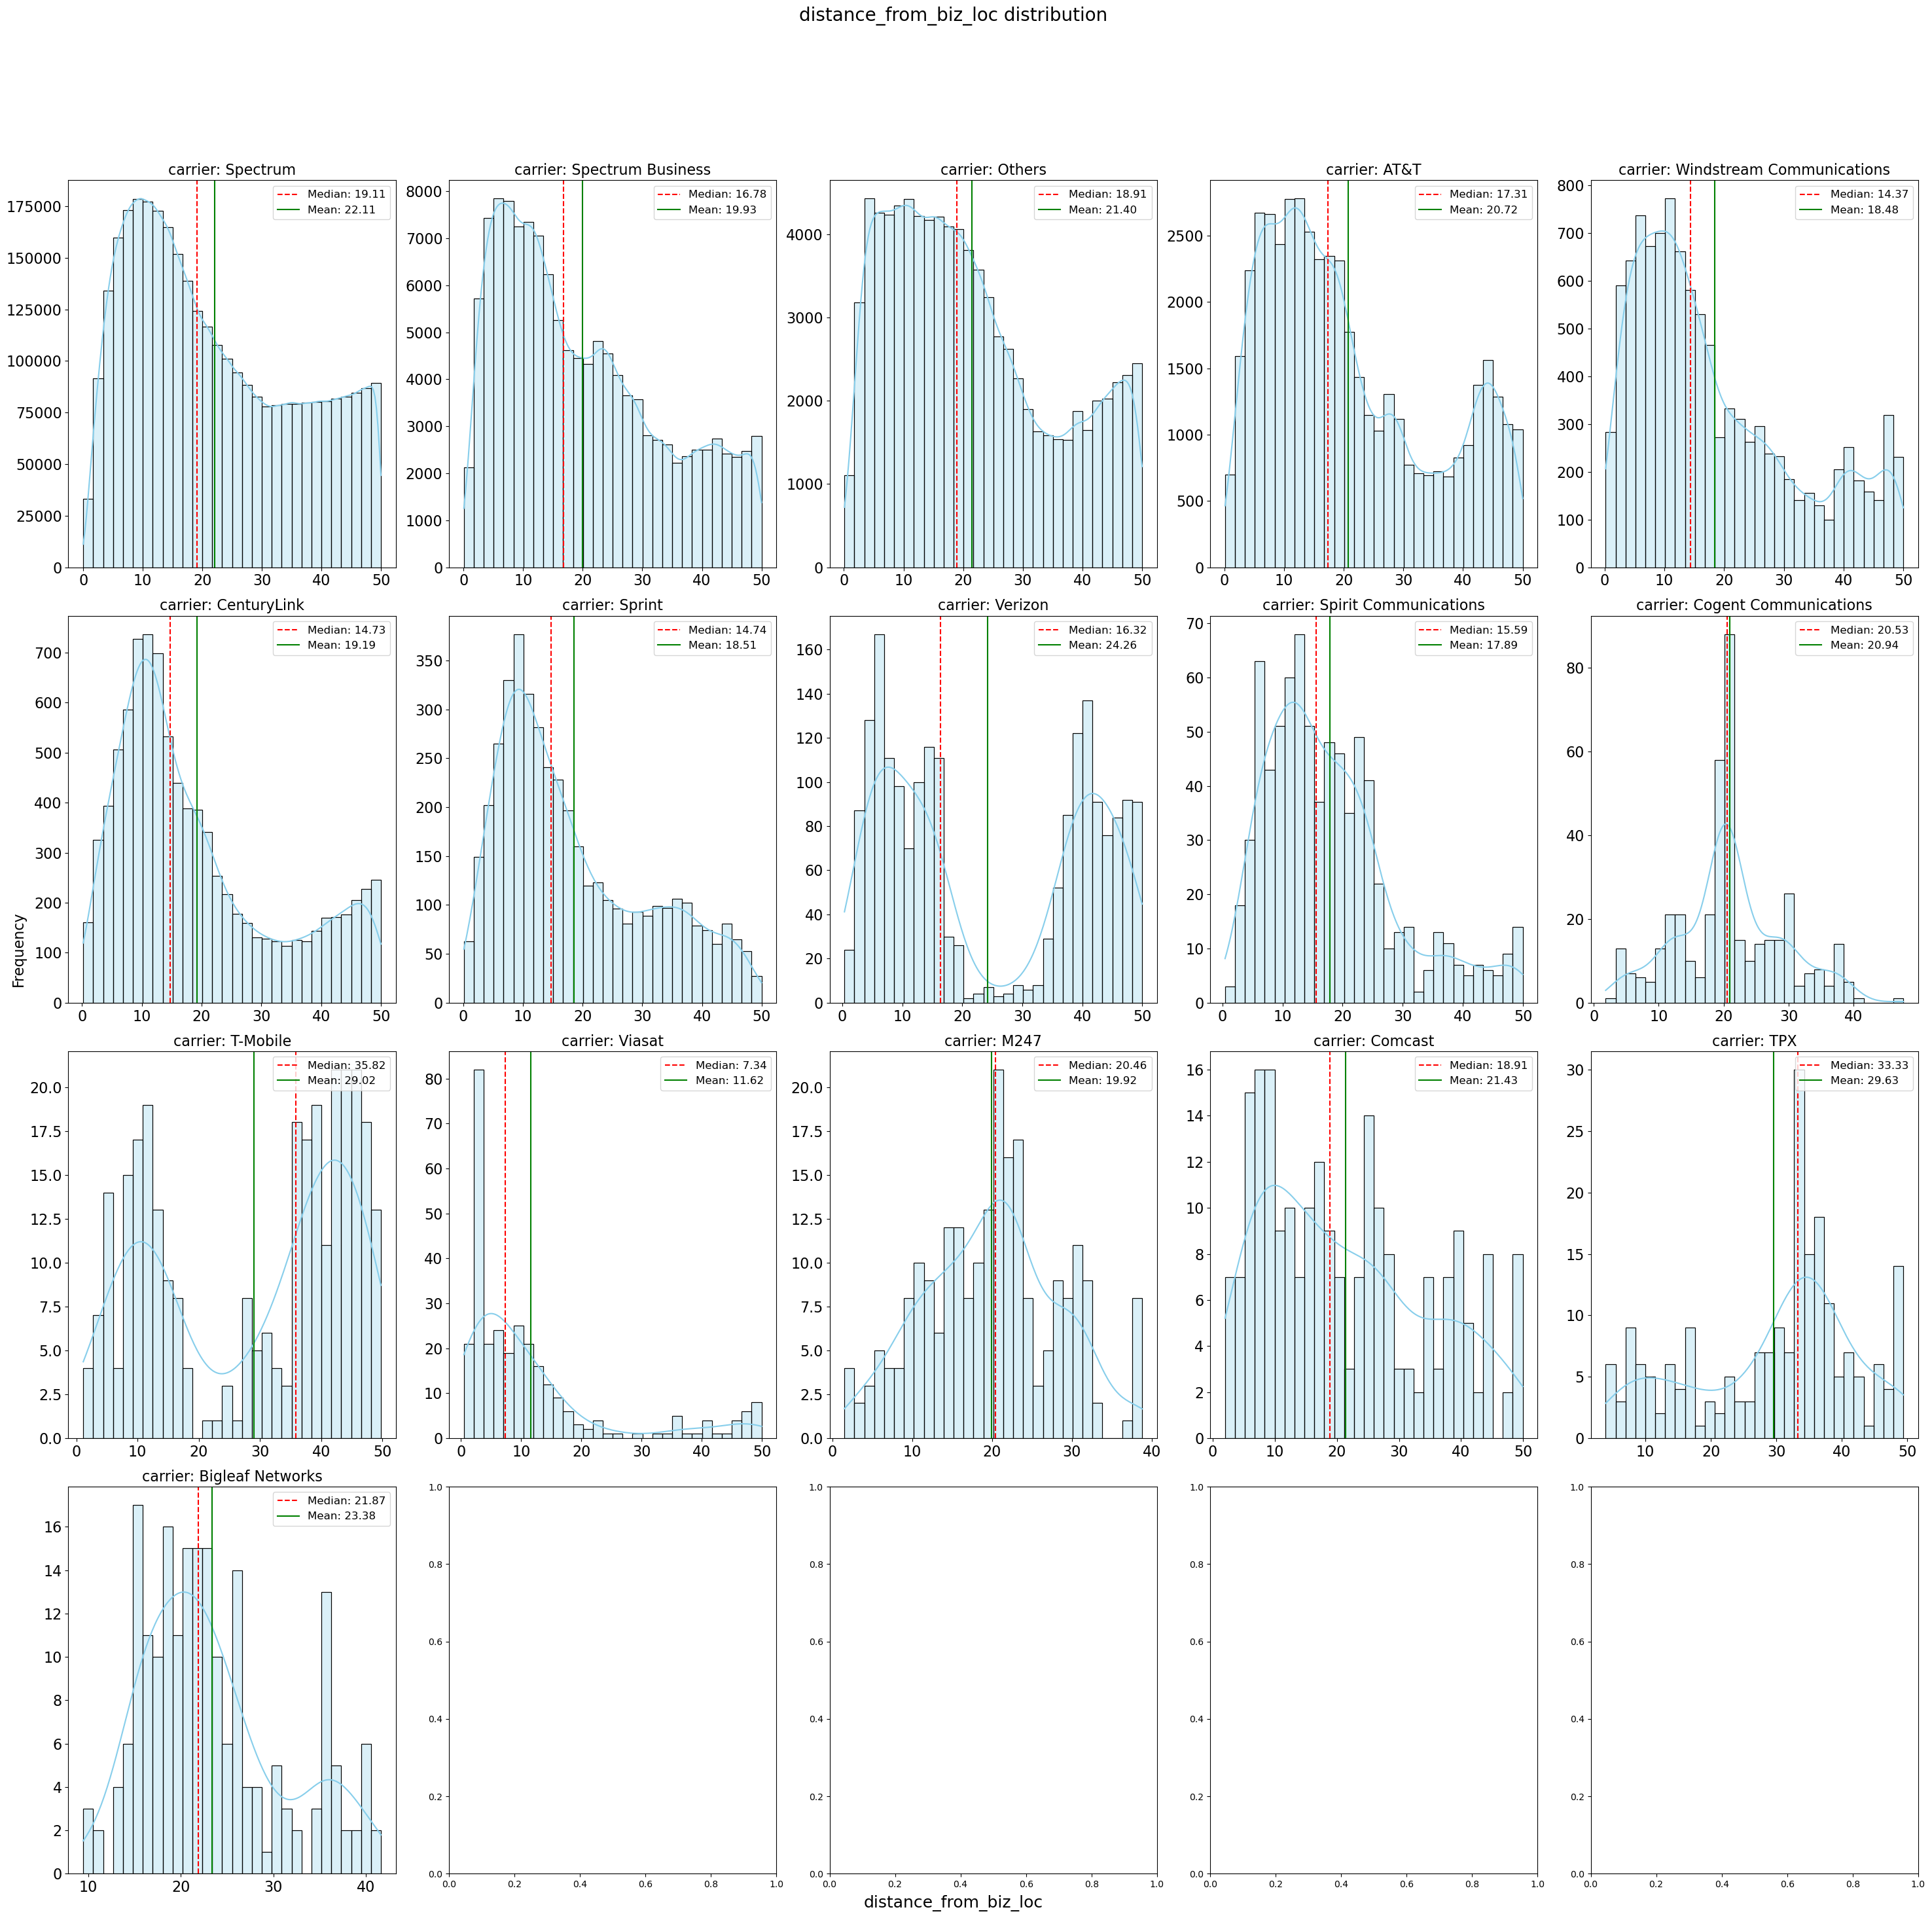

In [20]:
"""
Next, check distribution of "distance_from_biz_loc" for each carrier. We might potentially find the need to construct
additional new features

"""

nrows = math.ceil(len(carriers) / 5)
ncols = 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))
ax = ax.flatten()

filter_df = qm_data[qm_data["mapping_carrier"].isin(carriers)]
filter_df = filter_df.to_pandas()

for i, carr in enumerate(carriers):
    data = filter_df.query("mapping_carrier == @carr")
    sns.histplot(
        data["distance_from_biz_loc"],
        bins=30,
        kde=True,
        ax=ax[i],
        color="skyblue",
        alpha=0.3,
    )

    median_value = data["distance_from_biz_loc"].median()
    mean_value = data["distance_from_biz_loc"].mean()

    ax[i].axvline(
        median_value, color="red", linestyle="--", label=f"Median: {median_value:.2f}"
    )
    ax[i].axvline(
        mean_value, color="green", linestyle="-", label=f"Mean: {mean_value:.2f}"
    )

    ax[i].set_title(f"carrier: {carr}", fontsize=16)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].tick_params(axis="x", labelsize=16)  # Increase x-tick size
    ax[i].tick_params(axis="y", labelsize=16)  # Increase y-tick size

    ax[i].legend(loc="upper right", fontsize=12)


fig.supxlabel("distance_from_biz_loc", fontsize=18)
fig.supylabel("Frequency", fontsize=16)
plt.suptitle("distance_from_biz_loc distribution", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()

#### From the charts above

We can observe that the distribution of `distance_from_biz_loc` for **Verizon** and **T-Mobile** is atypically **bimodal**. Although the exact methodology behind the data collection process is unknown, it is possible that these networks have coverage gaps or uneven network connectivity. 

In other words, the network could have pockets of strong coverage whereas other carriers might have more consistent/homegenous coverage. To capture this heterogenous or multi-modal nature of distribution we create a new feature:

- `coverage_variability`: *Measured as the absolute difference between mean and median of business proximity (abs(mean - median))*


In [73]:
# Step 2: aggregate count_device, corporate_percentage, distance_from_biz_loc at carrier-level

df_spark = qm_data[qm_data["mapping_carrier"].isin(carriers)].to_spark()

aggregated_metrics = df_spark.groupby("mapping_carrier").agg(
    F.round(F.expr("percentile_approx(distance_from_biz_loc, 0.5)"), 3).alias(
        "median_biz_proximity"
    ),
    F.round(
        F.abs(
            F.mean("distance_from_biz_loc")
            - F.expr("percentile_approx(distance_from_biz_loc, 0.5)")
        ),
        3,
    ).alias("coverage_variability"),
    F.round(F.mean("corporateFlag"), 3).alias("corporate_percentage"),
    F.countDistinct("ifa_enc").alias("count_device"),  # Count occurrences of 'ifa_enc'
)

aggregated_metrics = aggregated_metrics.toPandas()
# aggregated_metrics.to_csv("aggregated_metrics_checkpoint.csv", index=False)

In [6]:
# aggregated_metrics = pd.read_csv("aggregated_metrics_checkpoint.csv")

In [7]:
# Create the final dataset to feed into SVD

train_data = aggregated_metrics.set_index("mapping_carrier")

train_data.head()

,median_biz_proximity,coverage_variability,corporate_percentage,count_device
mapping_carrier,,,,
CenturyLink,14.713,4.520,0.124,225
Spirit Communications,15.591,2.292,0.968,32
Comcast,18.628,2.602,0.105,25
Verizon,15.695,7.599,0.000,23
Viasat,7.890,3.943,0.000,7


### SVD on Quality Matrix

Singular Value Decomposition (SVD) reveals **latent factors** that drive relationships in data by decomposing a matrix into three components: left singular vectors (representing rows), singular values (indicating the importance of each hidden factor), and right singular vectors (capturing column patterns).

For ranking carriers based on attributes such as device count, corporate percentage, and signal distance, SVD uncovers hidden variables that explain differences in carrier performance. These latent factors may represent patterns like "corporate-focused carriers" or "broad coverage carriers", for example.

As a natural result of the SVD, a matrix is rendered (`Vt` below) which can be used to convert the observable attributes in our data to the unobservable underlying factors.

In [8]:
# QM is the final Quality Matrix on which SVD will be applied

QM = train_data[
    [
        "count_device",
        "median_biz_proximity",
        "coverage_variability",
        "corporate_percentage",
    ]
]
QM = QM[~QM.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [9]:
print("QUALITY MATRIX")
QM

QUALITY MATRIX


,count_device,median_biz_proximity,coverage_variability,corporate_percentage
mapping_carrier,,,,
CenturyLink,225,14.713,4.520,0.124
Spirit Communications,32,15.591,2.292,0.968
Comcast,25,18.628,2.602,0.105
Verizon,23,15.695,7.599,0.000
Viasat,7,7.890,3.943,0.000
Spectrum Business,1656,16.790,3.145,1.000
T-Mobile,20,36.280,7.132,0.000
Others,1761,18.860,2.515,0.477
Cogent Communications,12,20.529,0.451,0.993


In [10]:
# Normalize QM

for col in ["count_device", "median_biz_proximity", "coverage_variability"]:
    min_val = QM[col].min()
    max_val = QM[col].max()
    QM[col] = QM[col].apply(lambda x: (x - min_val) / (max_val - min_val))

In [11]:
"""
SVD:
Out of the possible four, we choose 2 strongest underlying latent factors that we wish to rank the carriers on.

Output of SVD:
U = Quality Matrix in terms of two latent factors.
Sigma = diagonal matrix which shows the relative importance of these two latent factors.
Vt = matrix which can be used on any matrix to return a new one (including Q) which contains the latent factor projection.

"""

n_components = 2
svd = TruncatedSVD(n_components=n_components)

U = svd.fit_transform(QM)
Sigma = svd.singular_values_
Vt = svd.components_

In [12]:
"""
The model reveals the following relative importance measures of the two latent factors (please see the following
markdown cell for more details)

"""

Sigma

array([2.78478736, 1.82911708])

In [110]:
Vt

array([[ 0.07847482,  0.53123102,  0.49590818,  0.68242976],
       [ 0.13825884,  0.21042848,  0.68855884, -0.68006696]])

### Interpreting the factors

We examine the above matrix `Vt` to get insights into the two factors whose relative importance is given by `Sigma`:
- The first row of `Vt` corresponds to the first factor. In this row the highest value (0.682) corresponds to the column "corporate_percentage." By the theory of SVD this means that this column is the biggest contributor to the first latent factor (most important factor). Since the column is "corporate_percentage", one may interpret the most important latent factor as likely being a measure of **popularity of a carrier among corporates.** 
- Similarly, the second row of `Vt` has the highest value (0.688) corresponding to the column "coverage_variability." This likely means that the second factor likely represents the notion of **network coverage** of a carrier.

## Ranking Process

The ranking logic is as follows: we generate similarity scores between each business unit and the carriers based on how close they are in terms of the underlying latent factors.

**Ranking logic:**
- Generate the latent factors of every business unit and every carrier *(as a reminder, these factors could be important but unquantifiable notions like "corporate-focus", "reach" etc.)*
- Cluster the business units (~7000) on the basis of these underlying latent factors 
- Within each cluster, generate similarity scores between businesses and carriers on the basis of these common latent factors
- For each business unit rank the carriers by their similarity scores


First we create the Business Feature Matrix (BFM) in terms of the observable attributes.

### Prepare Businesses Feature matrix



In [84]:
bm_spark = bm_data[bm_data["mapping_carrier"].isin(carriers)].to_spark()

filtered_df_spark = bm_spark.filter(
    (F.col("business_id").isNotNull()) & (F.col("business_id") != "None")
)

business_metrics = filtered_df_spark.groupby("business_id").agg(
    F.round(F.expr("percentile_approx(distance_from_biz_loc, 0.5)"), 3).alias(
        "median_biz_proximity"
    ),
    F.round(
        F.abs(
            F.mean("distance_from_biz_loc")
            - F.expr("percentile_approx(distance_from_biz_loc, 0.5)")
        ),
        3,
    ).alias("coverage_variability"),
    F.round(F.mean("corporateFlag"), 3).alias("corporate_percentage"),
    F.countDistinct("ifa_enc").alias("count_device"),  # Count unique devices
)

In [85]:
business_metrics = business_metrics.toPandas()
# business_metrics.to_csv("business_metrics_checkpoint.csv", index=False)

In [13]:
# business_metrics = pd.read_csv("business_metrics_checkpoint.csv")

In [14]:
# Create BFM and align its columns as per the columns of QM. This is a CRITICAL step of this exercise.

BFM = business_metrics.set_index("business_id")
BFM = BFM[
    [
        "count_device",
        "median_biz_proximity",
        "coverage_variability",
        "corporate_percentage",
    ]
]
# BFM.to_csv("business_features_matrix.csv", index=False)

print("BUSINESS FEATURE MATRIX")
BFM.head()

BUSINESS FEATURE MATRIX


,count_device,median_biz_proximity,coverage_variability,corporate_percentage
business_id,,,,
00155432bc686ccdcce4335b160a5fa8_a343fcbfe12032bd3c13dcf2ea7d255d,16,18.023,0.292,0.000
0037f93cf06688c42ea875c211e42819_d4dd928c172bc7a9398caece4efb63e9,8,36.306,1.913,0.000
0103930a28a321a2f66a8a6767becf10_94ffa707523be051a0f434ed6b65417d,6,22.939,2.077,0.000
0132134a9184481bd247c77b5554ff71_34505caa40cbfdd3ed6b58f029c3a679,25,14.575,1.719,0.018
0209c25f1e68a61937c52c6ea25ac405_1fdb2bec827d5007f5b3b25fbd4387b1,13,14.540,0.119,0.000


### Generate the *Latent Factors* for each business unit of the BFM

In [15]:
# Normalize count_device, device_variety and median_distance_from_biz

for col in ["count_device", "median_biz_proximity", "coverage_variability"]:
    min_val = BFM[col].min()
    max_val = BFM[col].max()
    BFM[col] = BFM[col].apply(lambda x: (x - min_val) / (max_val - min_val))

In [16]:
# Obtain Latent Factor representation of BFM

norms = np.linalg.norm(BFM, axis=1, keepdims=True)
BFM_normalized = BFM / norms

business_latent_factors = BFM_normalized.dot(Vt.T)

### Cluster business units on the basis of their Latent Factors

We use K-means algorithm to identify 3 clusters on the basis of the following Elbow curve


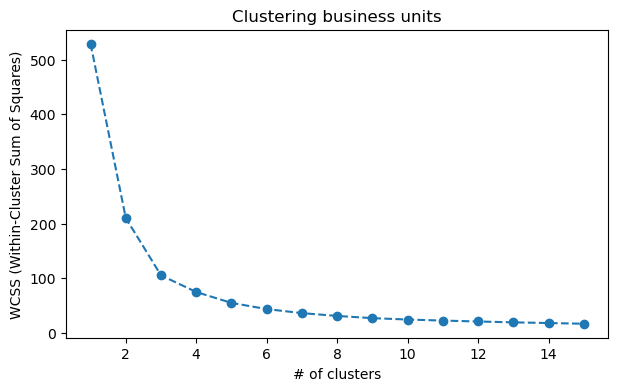

In [104]:
def business_elbow_curve(data, max_clusters=15):
    wcss = []
    for n_clusters in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, max_clusters + 1), wcss, marker="o", linestyle="--")
    plt.xlabel("# of clusters")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Clustering business units")
    plt.show()


business_elbow_curve(business_latent_factors, max_clusters=15)

In [17]:
kmeans_businesses = KMeans(n_clusters=3, random_state=42)
business_clusters = kmeans_businesses.fit_predict(business_latent_factors)

### Similarity scores between *Businesses* and *Carriers*

In [18]:
"""
Similarity scores are obtained by taking the dot product of business_latent_factors and carrier_latent_factors (U.T)

"""

similarity_matrix = np.dot(business_latent_factors, U.T)

rankings_by_cluster = {}

for cluster_id in np.unique(business_clusters):
    # Get the businesses in the current cluster
    cluster_businesses = np.where(business_clusters == cluster_id)[0]

    # Rank these businesses for each carrier
    cluster_similarity = similarity_matrix[cluster_businesses]
    cluster_rankings = np.argsort(
        -cluster_similarity, axis=1
    )  + 1 # Sort in descending order

    business_id = BFM.iloc[cluster_businesses].index
    rankings_by_cluster[cluster_id] = pd.DataFrame(
        cluster_rankings, index=business_id
    )  # Store rankings for each cluster

#### Ranking is saved cluster-wise in the dictionary `ranking_by_cluster.` 

Each item in this dictionary is a DataFrame where the index indicates business_id and the columns indicate the 16 carriers. The value in each column is the rank awarded to the carrier indexed by that column. 

Carrier-index catalog is obtained by:
`carrier_index_dict = {index:carrier for index,carrier in enumerate(QM.index)}`

The catalog is shown here:

*{0: 'CenturyLink',
 1: 'Spirit Communications',
 2: 'Comcast',
 3: 'Verizon',
 4: 'Viasat',
 5: 'Spectrum Business',
 6: 'Cogent Communications',
 7: 'Bigleaf Networks',
 8: 'T-Mobile',
 9: 'Others',
 10: 'Sprint',
 11: 'Spectrum',
 12: 'M247',
 13: 'Windstream Communications',
 14: 'AT&T'}*

**Reading the ranking table**

A sample ranking table is shown below. This is for `cluster 1` which covers 3997 business units.
The numbers in each row indicate the rank given to the carrier indexed by the column number. 

For example, for the first business_id:
- Rank 1 is in column numbered "6" which corresponds to "Cogent Communications" from the catalog above
- Rank 2 is in column numbered "5" which corresponds to "Spectrum Business"
- Rank 5 is in column numbered "14" which corresponds to "AT&T" etc.


In [22]:
rankings_by_cluster[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
business_id,,,,,,,,,,,,,,,
00155432bc686ccdcce4335b160a5fa8_a343fcbfe12032bd3c13dcf2ea7d255d,7,4,6,10,12,2,1,8,14,9,13,15,11,3,5
0037f93cf06688c42ea875c211e42819_d4dd928c172bc7a9398caece4efb63e9,7,4,6,10,12,2,1,8,14,9,13,15,11,3,5
0103930a28a321a2f66a8a6767becf10_94ffa707523be051a0f434ed6b65417d,7,4,6,12,1,10,2,8,14,15,11,3,9,13,5
0132134a9184481bd247c77b5554ff71_34505caa40cbfdd3ed6b58f029c3a679,7,4,6,12,1,10,14,8,2,15,11,3,9,13,5
0209c25f1e68a61937c52c6ea25ac405_1fdb2bec827d5007f5b3b25fbd4387b1,7,4,6,10,2,12,1,8,14,9,13,15,11,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe32eb0ffbac0c194c5ef9275601d297_58e277a0fc784e7716547cf08070fbd0,7,4,6,10,12,1,2,8,14,9,15,13,11,3,5
fe60461c7b88e8fcfc472c7a149cfed3_d98014844bbef380e28f05d0f60de7fd,7,4,6,10,12,2,1,8,14,9,15,13,11,3,5
feb5e5ca41eb0fa95acb47b4172cf1b0_03c062112cf87dcdfdd69c7ea409b2fa,7,4,6,10,12,1,2,8,14,15,9,11,13,3,5


### Validation

The core validation of our ranking approach is based on the hypothesis that there are distinct, characteristic latent factors that can map businesses to carriers effectively. To validate this, the best method would involve external validation—leveraging external datasets, including public data or results from other use cases, to verify that the underlying factors align with real-world patterns and expectations.

A secondary, fallback validation method is to **compare the clustering results**: one based on the observable attributes in the data and another based on the latent factors extracted through SVD modeling. In this case, the latent factor space derived from **QM** (through SVD) is used to project the observable attributes of **BFM**, with the assumption that both matrices share common latent factors. Clustering results from this projection should reflect whether the shared latent structure enhances the clustering of businesses in relation to carriers.

Interestingly, the silhouette scores obtained from clustering based on the latent factors are consistently higher for any number of clusters when compared to those based solely on observable attributes. This suggests that the latent factors derived from **QM** provide a more coherent and meaningful representation of the data, leading to better-defined clusters. 

While this clustering comparison provides useful insights into how well the model captures the structure of the data, it serves more as a check on internal consistency rather than external validation. Ultimately, external validation (through public data or other independent but related use-cases, for example) is the most reliable way to ensure that the factors driving the ranking are both relevant and actionable, while clustering comparisons can offer an additional layer of reassurance about the internal robustness of the model.


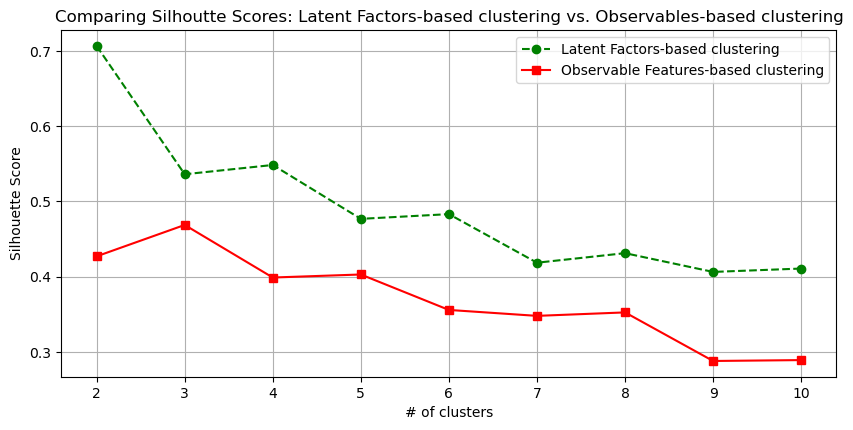

In [131]:
# Silhouette scores for Latent Factors-based clustering
latent_silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(business_latent_factors)
    score = silhouette_score(business_latent_factors, labels)
    latent_silhouette_scores.append(score)

# Silhouette scores for Observable Features-based clustering
observable_silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(BFM)
    score = silhouette_score(BFM, labels)
    observable_silhouette_scores.append(score)

plt.figure(figsize=(10, 4.5))
plt.plot(
    range(2, 11),
    latent_silhouette_scores,
    marker="o",
    linestyle="--",
    color="g",
    label="Latent Factors-based clustering",
)
plt.plot(
    range(2, 11),
    observable_silhouette_scores,
    marker="s",
    linestyle="-",
    color="r",
    label="Observable Features-based clustering",
)
plt.xlabel("# of clusters")
plt.ylabel("Silhouette Score")
plt.title(
    "Comparing Silhoutte Scores: Latent Factors-based clustering vs. Observables-based clustering"
)
plt.xticks(range(2, 11))
plt.legend()
plt.grid()
plt.show()

### Conclusion  

This project presents a structured approach to ranking telecom carriers for businesses by leveraging observable attributes and latent factors inferred through Singular Value Decomposition (SVD). The key hypothesis driving this methodology is the existence of shared latent factors between carrier attributes and business profiles, which can be exploited to uncover hidden patterns and produce a meaningful ranking.  

The results of the analysis support this hypothesis: clustering based on latent factors consistently yields higher silhouette scores compared to clustering based on observable attributes alone. This suggests that the latent factors derived from the quality matrix (QM) effectively capture deeper, more meaningful relationships between businesses and carriers, leading to better-defined clusters.  

However, this approach relies on several assumptions some of which are listed below (including scope for improvement):  
- **Geospatial spread limitations:** Geospatial spread at the carrier level was informative, but the sparse business-feature matrix (BFM), resulting from limited geographic data, posed challenges for analysis. A more geographically diverse dataset could make these features more valuable.  
- **Device variety analysis not performed:** Due to the large number of null values in the device characterizing columns, device variety could not be reliably calculated. While this dimension couldn’t be fully explored, it would have been an interesting aspect to investigate further, as exploring device-carrier compatibility could provide valuable insights into how different device types interact with carriers and how businesses are affected by these dynamics.
- **Shared business attributes from the same address:** Multiple businesses sharing attributes from the same address was accounted for by clustering business locations, but this introduces the assumption that these clusters appropriately represent distinct business needs.  
- **Assumptions in applying SVD:** Using SVD to infer latent factors assumes that the data matrices (QM and BFM) are structured in a way that relationships between their elements can be effectively captured by linear decompositions. It also assumes that the most significant patterns in the data are captured by the largest singular values and corresponding singular vectors, which may not always hold true for highly noisy or unstructured data.  

While the comparison of clustering outcomes demonstrates internal consistency, true validation of the ranking approach lies in external validation. This would involve testing the underlying factors against independent datasets, public data, or insights from related use cases. Such external validation is essential to ensure that the latent factors not only improve clustering performance but also align with real-world patterns and deliver actionable insights.  

In summary, this approach highlights the potential of latent factor modeling in uncovering hidden relationships and refining business decisions. While the results are promising, addressing these assumptions and conducting external validation are critical steps to establish the reliability and generalizability of the proposed ranking framework.  


##### Appendix

In [20]:
"""
CONFIRM THAT CHOOSING "mapping_carrier" INSTEAD of "carrier" DOES NOT INVALIDATE RESULTS

STEPS:
1) Create a binary column "mismatch" where a value of 1 indicates "mapping_carrier" != "carrier"
2) Where mismatch == 1, see distribution of data
3) We observe that in majority of the mismatched rows, and where "num_of_rows" > 200, the "mapping_carrier" column has always 
taken a value that is in the set of the 15 carriers that we considered in our analysis.
4) For the other mismatched rows, the volume is < 200 and hence they would have been dropped from the analysis anyway

"""

psdf_geo["corporateFlag"] = psdf_geo["corporateFlag"].astype(int)
cols_of_interest = [
    "ifa_enc",
    "mapping_carrier",
    "carrier",
    "corporateFlag",
    "distance_from_biz_loc",
]
check_df = psdf_geo[cols_of_interest]
check_df = check_df.drop_duplicates()

check_df["mismatch"] = (check_df["mapping_carrier"] != check_df["carrier"]).astype("int")
check_df[check_df["mismatch"] == 1].groupby(["mapping_carrier", "carrier"]).size().sort_values(ascending=False).reset_index(name="num_of_rows")


,mapping_carrier,carrier,num_of_rows
0,AT&T,AT&T Internet,41630
1,Others,NorthState,33862
2,Others,Lumen,21512
3,Others,Zscaler,6703
4,Others,Network Innovations,3132
5,AT&T,AT&T Services,2604
6,Others,Yadkin Valley Telephone,2602
7,Others,Novant Health,2230
8,Others,North Carolina Research and Education Network,1796
9,Verizon,Verizon Wireless,1723
